# Statistical Modelling 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.formula.api import *

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext

warnings.filterwarnings("ignore")

In [2]:
ytx_2018_pdf = pd.read_parquet('../preprocessed_data/ytx_2018_sample.parquet/')

In [3]:
ytx_2019_pdf = pd.read_parquet('../preprocessed_data/ytx_2019_sample.parquet/')

> As we know from feature analysis, most features are skewed

## Ridge Regression

In [4]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

y_variable = ytx_2018_pdf[['tip_amount']]
X_variable = ["trip_distance", "trip_duration", "fare_amount", "avg_speed", 
              "tolls_amount", "wind_angle_degrees", "wind_speed_mps", "air_temp_celsius",
              "dew_temp_celsius", "sky_ceil_height_meters", "vis_distance_meters", "atp_hectopascals"]

# Standardised X_variable before fitting into a model
X_standard = ytx_2018_pdf[X_variable].astype(float).apply(zscore)

# Train Test split as usual
X_train, X_test, y_train, y_test = train_test_split(X_standard, y_variable, test_size = 0.8, random_state = 17)

# Format output to 4 decimal places 
# (Taken from Lab 3 Python MAST30034 - 2021)
pd.options.display.float_format = '{:,.4f}'.format
X_standard.describe().loc[['mean','std']]

,trip_distance,trip_duration,fare_amount,avg_speed,tolls_amount,wind_angle_degrees,wind_speed_mps,air_temp_celsius,dew_temp_celsius,sky_ceil_height_meters,vis_distance_meters,atp_hectopascals
mean,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [5]:
from glmnet import ElasticNet

# ElasticNet with parameter:
# => alpha = 0 means Ridge Regression 
# => alpha = 1 means Lasso Regression
ridge_fit = ElasticNet(alpha=0)
ridge_fit.fit(X_train.values, y_train.values)

ElasticNet(alpha=0)

In [6]:
# glmnet can find the best lambda by cross-validation
lamb = ridge_fit.lambda_best_[0]
print(f'Best lambda value for Ridge: {lamb}')

Best lambda value for Ridge: 0.9639270164525456


In [7]:
pd.DataFrame(index = ['Intercept'] + X_variable, 
             data= [ridge_fit.intercept_] + list(ridge_fit.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,2.4876
trip_distance,0.3409
trip_duration,0.3603
fare_amount,0.3797
avg_speed,0.0938
tolls_amount,0.2181
wind_angle_degrees,0.0020
wind_speed_mps,0.0078
air_temp_celsius,-0.0020
dew_temp_celsius,-0.0063


In [8]:
ridge_fit.score(X_train, y_train, lamb = lamb)

array(0.4863819)

In [9]:
ridge_fit.score(X_test, y_test, lamb = lamb)

array(0.46689282)

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    labels = ['R squared', 'Mean Absolute Error', 'Mean Squared Error']
    score = [r2, mae, mse] 
    
    for i in range(len(labels)):
        print(f"{labels[i]} : {score[i]}")

In [17]:
evaluate_model(y_train, ridge_fit.predict(X_train))

R squared : 0.486381901056016
Mean Absolute Error : 0.7408431263423358
Mean Squared Error : 1.9817946753806919


In [16]:
evaluate_model(y_test, ridge_fit.predict(X_test))

R squared : 0.46689281823662687
Mean Absolute Error : 0.7410153050998414
Mean Squared Error : 2.127203422386535


In [12]:
# 2019 Predictions
X_standard_2019 = ytx_2019_pdf[X_variable].astype(float).apply(zscore)
y_pred_2019 = ridge_fit.predict(X_standard_2019)
evaluate_model(ytx_2019_pdf['tip_amount'], y_pred_2019)

R squared : 0.30706564933938796
Mean Absolute Error : 1.0074923009939925
Mean Squared Error : 3.1714052731536717


### Correlation of Tip Amount with other Features

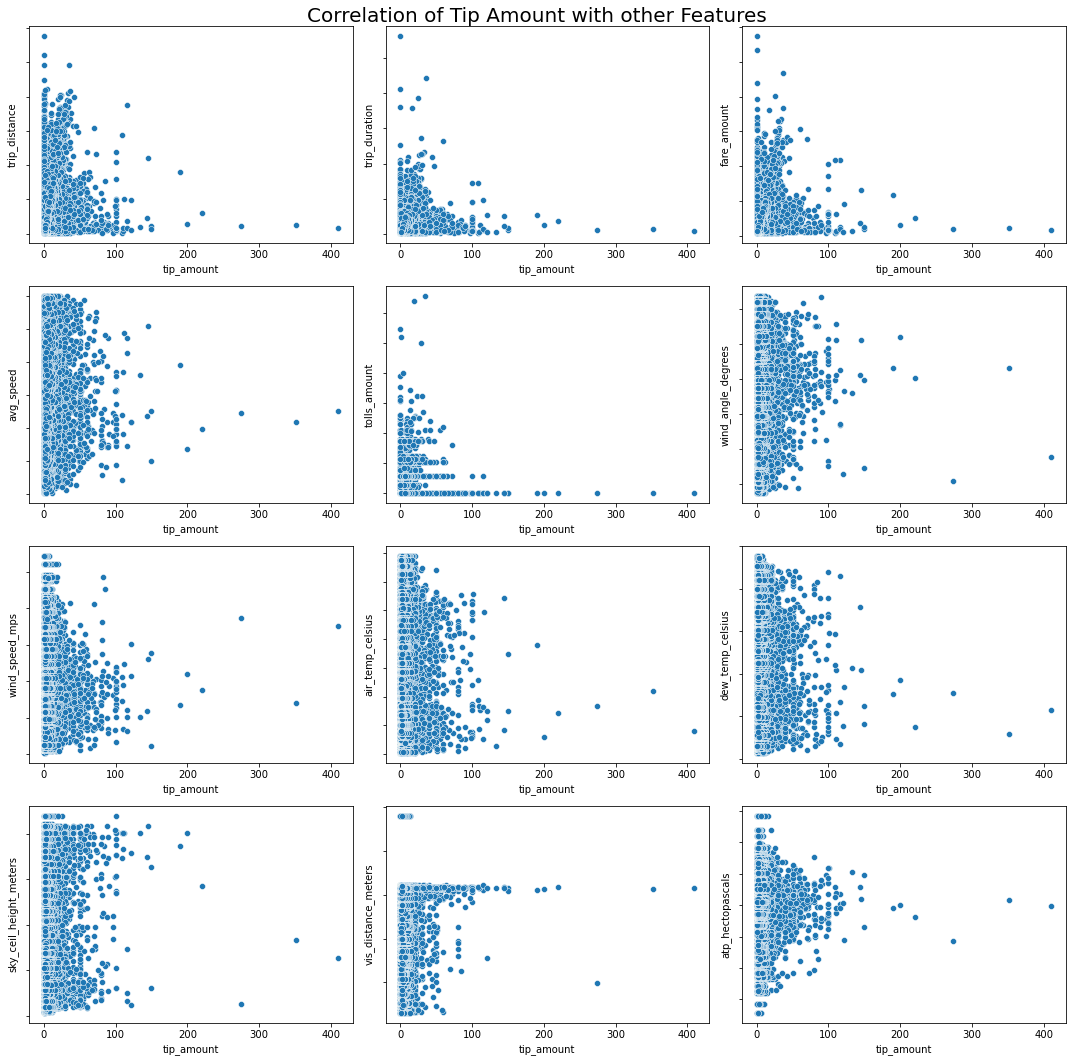

In [18]:
import seaborn as sns
fig, axs = plt.subplots(4, 3, figsize = (15, 15))
labels = ["trip_distance", "trip_duration", "fare_amount", "avg_speed", "tolls_amount", 
          "wind_angle_degrees", "wind_speed_mps", "air_temp_celsius", "dew_temp_celsius", 
          "sky_ceil_height_meters", "vis_distance_meters", "atp_hectopascals"]

count = 0
for i in range(4):
    for j in range(3):
        sns.scatterplot(x = ytx_2018_pdf['tip_amount'], y = ytx_2018_pdf[labels[count]], ax = axs[i, j])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_ylabel(labels[count])
        count += 1
        
fig.suptitle('Correlation of Tip Amount with other Features', fontsize = 20)
fig.tight_layout()
fig.savefig('../plots/tip_correlation.png')

### Independent Features Correlations

In [19]:
ind_features = ytx_2018_pdf[["trip_distance", "trip_duration", "fare_amount", "tolls_amount"]]

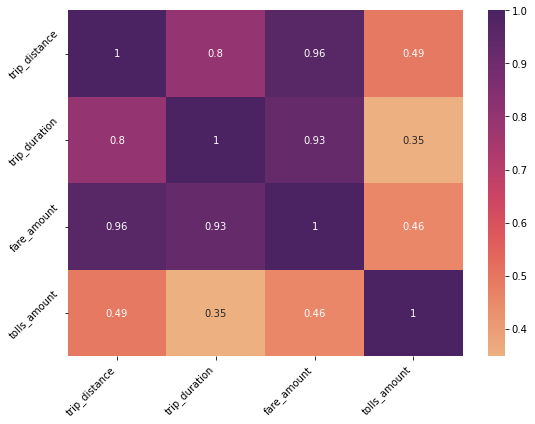

In [20]:
f1, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(ind_features.corr(), cmap = "flare", annot = True)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, horizontalalignment='right')
axs.set_yticklabels(axs.get_yticklabels(), rotation=45, horizontalalignment='right')
f1.tight_layout()
f1.savefig('../plots/independent_correlations.png')